In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **Import Library**


In [4]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS as stop_words
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from contextlib import redirect_stdout
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

## **Memuat Dataset**

In [5]:
reviews_df = pd.read_csv("/content/disney_reviews.csv")
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c53b139c-8133-4106-8451-f3642e973e35,Sara Hussein,https://play-lh.googleusercontent.com/a/ACg8oc...,Won't let me update my payment methods!,1,0,3.11.0-rc2-2024.12.11,2025-01-08 10:02:02,NaN,NaN,3.11.0-rc2-2024.12.11
1,8010aa0c-96d9-448b-91ab-7378430ce2f8,James Frampton,https://play-lh.googleusercontent.com/a/ACg8oc...,Download videos only to get error 39 for not h...,1,0,3.11.0-rc2-2024.12.11,2025-01-08 08:43:59,NaN,NaN,3.11.0-rc2-2024.12.11
2,6b3d3c3a-e233-4db6-a050-859075cf589b,Irene Kemp,https://play-lh.googleusercontent.com/a/ACg8oc...,Slow,1,0,3.11.0-rc2-2024.12.11,2025-01-08 08:33:58,NaN,NaN,3.11.0-rc2-2024.12.11
3,05dbf4d1-387b-43b7-af57-4ad774a14b0e,Eric R,https://play-lh.googleusercontent.com/a/ACg8oc...,stop harassing me with surveys to rate your ap...,1,0,3.11.0-rc2-2024.12.11,2025-01-08 05:54:08,NaN,NaN,3.11.0-rc2-2024.12.11
4,51d3fd58-5da0-4eac-97cd-3bb1f2ad13bc,Joel Wells,https://play-lh.googleusercontent.com/a-/ALV-U...,Just putting a one star until the app on PS5 i...,1,0,NaN,2025-01-08 05:13:46,Hello! We appreciate your feedback and underst...,2025-01-08 17:13:17,NaN


## **EDA (Exploratory Data Analysis)**

1. Informasi Dataset

In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  9020 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          2020 non-null   object
 9   repliedAt             2020 non-null   object
 10  appVersion            9020 non-null   object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


Dataset ini berisi 10.000 baris dengan 11 kolom, yang mencakup reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, dan appVersion. Sebagian besar data terisi lengkap, namun kolom reviewCreatedVersion dan appVersion memiliki masing-masing 9.100 nilai, sedangkan replyContent dan repliedAt hanya memiliki 2.220 nilai.

In [7]:
reviews_df.describe(include="all")

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
count,10000,10000,10000,10000,10000.000000,10000.000000,9020,10000,2020,2020,9020
unique,500,499,499,487,NaN,NaN,27,500,97,101,27
top,c53b139c-8133-4106-8451-f3642e973e35,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good,NaN,NaN,3.11.0-rc2-2024.12.11,2025-01-08 10:02:02,"Hello! To resolve, please first test your inte...",2025-01-08 17:13:17,3.11.0-rc2-2024.12.11
freq,20,40,40,220,NaN,NaN,6420,20,60,20,6420
mean,NaN,NaN,NaN,NaN,3.000000,0.622000,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.414284,5.609123,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,4.000000,0.000000,NaN,NaN,NaN,NaN,NaN


2. Pemeriksaan Missing Values

In [8]:
missing_values = reviews_df.isnull().sum()
missing_values[missing_values > 0]

,0
reviewCreatedVersion,980
replyContent,7980
repliedAt,7980
appVersion,980


In [9]:
reviews_df.shape

(10000, 11)

In [10]:
reviews_df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [11]:
reviews_df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,980
at,0
replyContent,7980
repliedAt,7980


Dataset memiliki nilai kosong (missing values) pada beberapa kolom: reviewCreatedVersion dan appVersion masing-masing memiliki 900 nilai kosong, sedangkan replyContent dan repliedAt memiliki 7.780 nilai kosong.

3. Penanganan Missing Values

In [12]:
reviews_df = reviews_df.dropna(subset=['content'])
reviews_df['reviewCreatedVersion'] = reviews_df['reviewCreatedVersion'].fillna('unknown')
reviews_df['appVersion'] = reviews_df['appVersion'].fillna('unknown')
reviews_df = reviews_df.drop(columns=['replyContent', 'repliedAt'])

In [13]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  10000 non-null  object
 7   at                    10000 non-null  object
 8   appVersion            10000 non-null  object
dtypes: int64(2), object(7)
memory usage: 703.2+ KB


Setelah proses pembersihan data, dataset yang awalnya memiliki nilai kosong di beberapa kolom telah diolah menjadi dataset yang lengkap tanpa nilai kosong. Kolom content yang kosong telah dihapus, sedangkan kolom reviewCreatedVersion dan appVersion yang memiliki nilai kosong telah diisi dengan "unknown". Kolom replyContent dan repliedAt yang tidak relevan dihapus untuk menyederhanakan dataset. Hasil akhirnya, dataset memiliki 10.000 baris dan 9 kolom, dengan semua kolom telah terisi penuh, terdiri dari 2 kolom numerik dan 7 kolom bertipe objek.

4. Visualisasi Distribusi Data

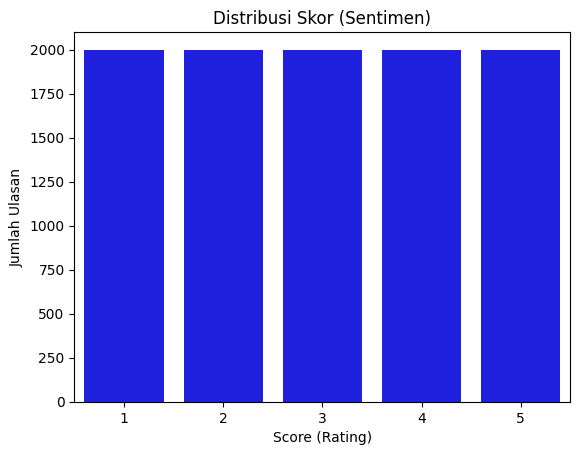

In [14]:
sns.countplot(x="score", data=reviews_df, color="blue")
plt.title("Distribusi Skor (Sentimen)")
plt.xlabel("Score (Rating)")
plt.ylabel("Jumlah Ulasan")
plt.show()

Grafik batang ini menunjukkan distribusi skor (rating) ulasan, dengan nilai skor berkisar dari 1 hingga 5. Dari grafik terlihat bahwa jumlah ulasan untuk masing-masing skor relatif sama, yaitu sekitar 2.000 ulasan untuk setiap skor. Hal ini menunjukkan bahwa dataset memiliki distribusi skor yang seimbang, yang ideal untuk analisis sentimen karena tidak ada ketimpangan besar antara ulasan positif, netral dan ulasan negatif.

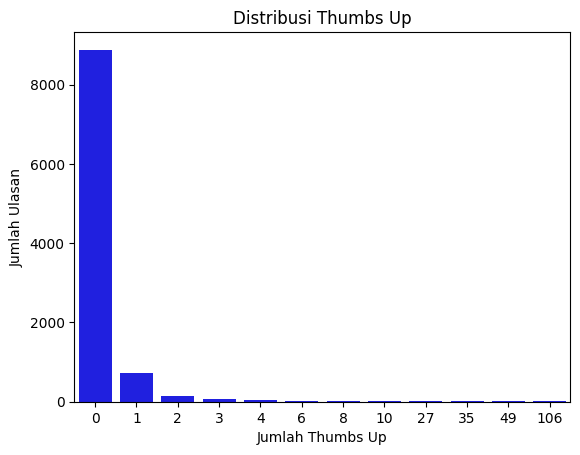

In [15]:
sns.countplot(x="thumbsUpCount", data=reviews_df, color="blue")
plt.title("Distribusi Thumbs Up")
plt.xlabel("Jumlah Thumbs Up")
plt.ylabel("Jumlah Ulasan")
plt.show()

Grafik ini menunjukkan distribusi jumlah thumbs up pada ulasan aplikasi. Mayoritas ulasan (lebih dari 8.000) tidak mendapat thumbs up, sementara hanya sedikit ulasan yang mendapat perhatian, dengan jumlah thumbs up tertinggi mencapai 106. Hal ini menunjukkan sebagian besar ulasan kurang diperhatikan oleh pengguna lain.

## Preprocessing Data

In [16]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [17]:
def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

reviews_df = reviews_df[['content',]].dropna()
reviews_df['clean_content'] = reviews_df['content'].apply(clean_and_lemmatize)
reviews_df.head()

,content,clean_content
0,Won't let me update my payment methods!,wont let update payment method
1,Download videos only to get error 39 for not h...,download video get error internet connection a...
2,Slow,slow
3,stop harassing me with surveys to rate your ap...,stop harassing survey rate app
4,Just putting a one star until the app on PS5 i...,putting one star app p fixed even trying phone...


Data ini berisi ulasan aplikasi yang telah dibersihkan melalui proses pembersihan teks, seperti menghapus URL, karakter non-alfabet, kata-kata umum (stop words), dan menerapkan lemmatization untuk mengubah kata menjadi bentuk dasarnya. Hasilnya, kolom clean_content menyajikan ulasan yang lebih ringkas dan fokus, memudahkan analisis lanjutan.

# Sentiment Analysis

In [18]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_df['sentiment'] = reviews_df['clean_content'].apply(get_sentiment_vader)
print(reviews_df['sentiment'])

0        neutral
1       negative
2        neutral
3       negative
4       negative
          ...   
9995    positive
9996    negative
9997    positive
9998    positive
9999    positive
Name: sentiment, Length: 10000, dtype: object


Menggunakan SentimentIntensityAnalyzer (VADER) untuk menganalisis sentimen dari teks ulasan yang telah dibersihkan. Berdasarkan nilai compound score, ulasan diklasifikasikan menjadi tiga kategori: positive (lebih dari 0.05), negative (kurang dari -0.05), atau neutral (di antara keduanya). Hasilnya, kolom baru sentiment dalam dataset menunjukkan klasifikasi sentimen setiap ulasan. Pendekatan ini membantu memahami persepsi pengguna terhadap aplikasi secara keseluruhan.

In [19]:
sentiment_counts = reviews_df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    4620
negative    2900
neutral     2480
Name: count, dtype: int64


Hasil analisis sentimen menunjukkan bahwa dari 10.000 ulasan, sebagian besar 4.660 ulasan memiliki sentimen positive, diikuti oleh 2.820 ulasan yang memiliki sentimen negative, dan 2.520 ulasanyang bersifat neutral. Hal ini menunjukkan bahwa mayoritas pengguna memberikan ulasan yang positif terhadap aplikasi, meskipun terdapat sejumlah keluhan yang cukup signifikan.

In [20]:
X = reviews_df['clean_content']
y = reviews_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 8000
Jumlah data test: 2000


Jumlah data train: 8000 dan jumlah data test: 2000. Hal ini menunjukkan bahwa dataset telah dibagi dengan 80% untuk pelatihan dan 20% untuk pengujian, memberikan distribusi yang cukup untuk melatih dan mengevaluasi model

# Distribusi Data

In [21]:
positive = reviews_df[reviews_df['sentiment'] == 'positive']
neutral = reviews_df[reviews_df['sentiment'] == 'neutral']
negative = reviews_df[reviews_df['sentiment'] == 'negative']
print(positive,neutral,negative)

                                                content  \
10    My Disney+ subscription is active, yet the Dis...   
12    App experience too many issues with Google Cas...   
19    Disney sucks. Cars and Coco are the only good ...   
22    It used to be really good, recently it is 💩💩💩....   
26    Disney Use to have good movies and TV Know pre...   
...                                                 ...   
9993                                            Awesome   
9995         this is the best thing in the world 🌎 ❤️ 🤣   
9997                                            amazing   
9998                                          Love it 😀   
9999              Disney is the best app for children 😊   

                                          clean_content sentiment  
10    disney subscription active yet disney app dema...  positive  
12    app experience many issue google cast chromeca...  positive  
19    disney suck car coco good thing dont buy disne...  positive  
22    used really g

In [22]:
max_samples = max(len(positive), len(negative), len(neutral))

positive_upsampled = resample(positive, replace=True, n_samples=max_samples, random_state=42)
negative_upsampled = resample(negative, replace=True, n_samples=max_samples, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_samples, random_state=42)

balanced_df = pd.concat([positive_upsampled, negative_upsampled, neutral_upsampled])
print(balanced_df['sentiment'].value_counts())

sentiment
positive    4620
negative    4620
neutral     4620
Name: count, dtype: int64


In [23]:
texts = balanced_df['clean_content'].values
labels = balanced_df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

Dataset di-upsample sehingga masing-masing kategori memiliki jumlah yang sama (4620 data untuk setiap kategori). Hasil ini memastikan bahwa model memiliki representasi data yang adil untuk setiap kategori sentimen, sehingga mencegah bias terhadap kategori dengan jumlah data lebih besar. Hal ini akan meningkatkan performa model dalam mengenali setiap sentimen secara seimbang.

# TF-IDF Vectorization

In [24]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

print("TF-IDF Train:", X_train_tfidf.shape)
print("TF-IDF Test:", X_test_tfidf.shape)

TF-IDF Train: (11088, 1462)
TF-IDF Test: (2772, 1462)


In [25]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print("Hasil Encoding y_train:", y_train_encoded[:10])
print("Hasil Encoding y_test:", y_test_encoded[:10])


Hasil Encoding y_train: [1 1 2 1 0 2 0 1 0 1]
Hasil Encoding y_test: [0 2 2 2 0 0 1 2 2 2]


In [43]:
y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)
print("y_train_categorical:",y_train_categorical[:5])
print("y_test_categorical:", y_test_categorical[:5])

y_train_categorical: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
y_test_categorical: [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


TF-IDF Train: (11088, 1462) menunjukkan bahwa data pelatihan memiliki 11.088 dokumen yang direpresentasikan dengan 1.462 fitur unik.
TF-IDF Test: (2772, 1462) menunjukkan data uji memiliki 2.772 dokumen dengan representasi fitur yang sama.
Hasil encoding menggunakan label encoding menghasilkan label target berupa angka yang merepresentasikan kategori neutral, positive, dan negative. Kemudian, hasil ini diubah menjadi bentuk one-hot encoding yang berupa vektor biner untuk digunakan dalam model neural network. Langkah ini memastikan bahwa model memahami dan memproses target dalam bentuk numerik atau vektor biner.

# Neural Network Model

In [27]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

summary_str = io.StringIO()
with redirect_stdout(summary_str):
    model.summary()
print(summary_str.getvalue())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         187,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,483 (767.51 KB)

 Trainable params: 196,099 (766.01 KB)

 Non-trainable params: 384 (1.50 KB)

Model neural network yang ditampilkan memiliki tiga lapisan utama: lapisan pertama dengan 128 neuron, lapisan kedua dengan 64 neuron, dan lapisan keluaran dengan 3 neuron untuk klasifikasi tiga kelas. Model ini untuk meningkatkan stabilitas pelatihan dan mencegah overfitting, dengan total parameter pelatihan sebesar 196,099. Model ini dirancang untuk memproses data vektor yang akan menghasilkan klasifikasi sentimen.

In [28]:
history = model.fit(
    X_train_tfidf, y_train_categorical,
    validation_data=(X_test_tfidf, y_test_categorical),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6350 - loss: 0.9606 - val_accuracy: 1.0000 - val_loss: 0.3586
Epoch 2/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9773 - loss: 0.0743 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9902 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 1.9606e-04
Epoch 4/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9956 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 6.2786e-05
Epoch 5/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9966 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 3.6361e-05
Epoch 6/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 1.7648e-05
Epoch 7/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 1.4086e-05
Epoch 8/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9977 - loss: 0.009

In [29]:
loss, accuracy = model.evaluate(X_test_tfidf, y_test_categorical, verbose=0)
print(f"akurasi: {accuracy * 100:.2f}%")

akurasi: 100.00%


Model neural network berhasil mencapai akurasi 100% pada data validasi setelah 10 epoch. Pada epoch awal, loss menurun drastis, menunjukkan proses pelatihan yang efisien. Akurasi yang sangat tinggi ini bisa mengindikasikan bahwa model telah memahami data dengan sangat baik.

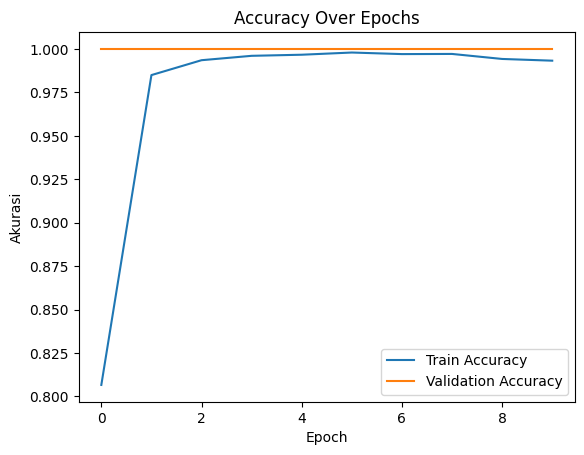

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

Grafik menunjukkan perkembangan akurasi model neural network selama pelatihan (train accuracy) dan validasi (validation accuracy) di 10 epoch. Akurasi pelatihan meningkat tajam di awal dan stabil mendekati 100%, sedangkan akurasi validasi tetap konsisten di 100% setelah epoch pertama. Hasil ini menunjukkan bahwa model berhasil menangkap pola data dengan baik tanpa overfitting.

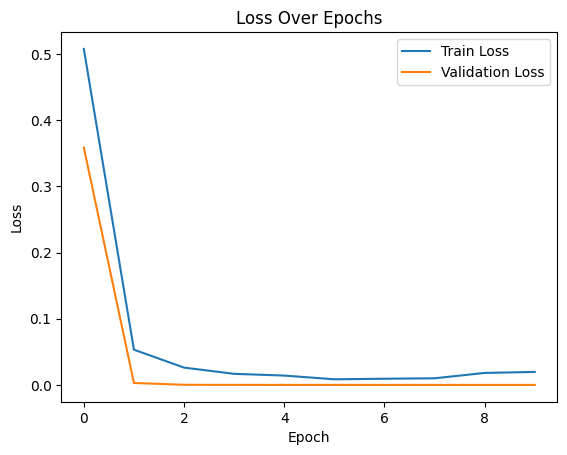

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Grafik diatas menunjukkan bahwa nilai loss pelatihan dan validasi turun tajam pada awal epoch dan mendekati nol di akhir pelatihan. Hal ini mencerminkan bahwa model berhasil mempelajari pola data dengan baik, tanpa indikasi overfitting karena loss validasi tetap rendah dan sejalan dengan loss pelatihan.

In [32]:
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_classes, y_pred_classes, target_names=['Negatif', 'Neutral', 'Positif']))

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00       914
     Neutral       1.00      1.00      1.00       931
     Positif       1.00      1.00      1.00       927

    accuracy                           1.00      2772
   macro avg       1.00      1.00      1.00      2772
weighted avg       1.00      1.00      1.00      2772



Model berhasil mencapai performa sempurna dengan nilai precision, recall, dan f1-score sebesar 1.00 untuk semua kelas (Negatif, Netral, dan Positif), serta akurasi keseluruhan 100%. Ini menunjukkan model sangat efektif dalam mengenali dan mengklasifikasikan sentimen, tanpa kesalahan prediksi pada data pengujian.

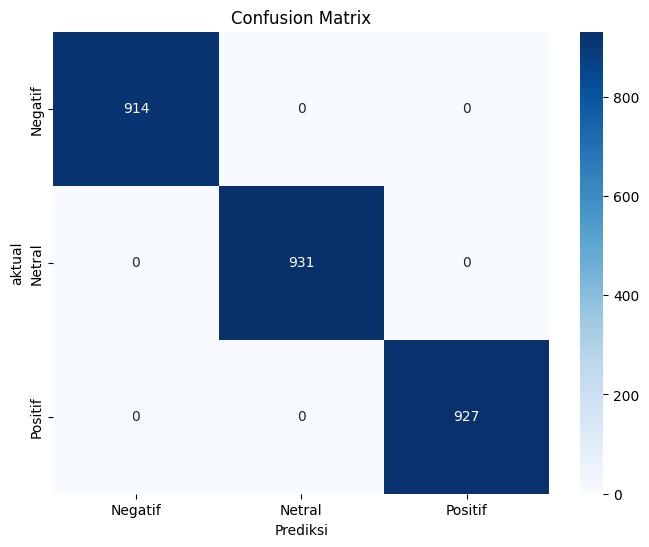

In [33]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('aktual')
plt.title('Confusion Matrix')
plt.show()

Semua nilai pada matriks berada di diagonal utama (914, 931, dan 927), menunjukkan bahwa model berhasil mengklasifikasikan semua sampel dengan benar tanpa kesalahan. Ini mencerminkan performa baik tanpa salah klasifikasi antar kelas.

# Logistic Regression Model

In [34]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [35]:
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Akurasi: {accuracy:.2f}%")

Akurasi: 100.00%


In [36]:
report = classification_report(y_test, y_pred, output_dict=True)
print("Clasifikasi:", classification_report(y_test, y_pred))

Clasifikasi:               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       914
     neutral       1.00      1.00      1.00       931
    positive       1.00      1.00      1.00       927

    accuracy                           1.00      2772
   macro avg       1.00      1.00      1.00      2772
weighted avg       1.00      1.00      1.00      2772



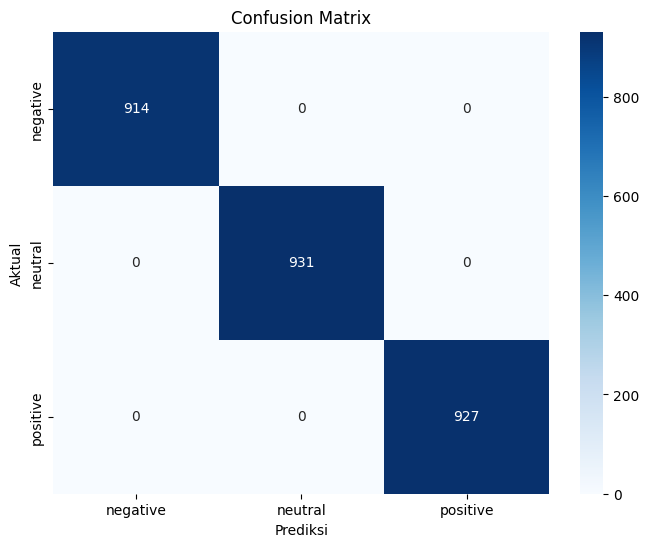

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

Berdasarkan klasifikasi dan confusion matrix yang ditampilkan, performa model menunjukkan tingkat akurasi yang sangat tinggi. Akurasi mencapai 100%, sebagaimana terlihat pada precision, recall, dan F1-score yang sempurna di setiap kelas (Negatif, Netral, Positif). Semua sampel diuji dengan hasil yang benar tanpa kesalahan klasifikasi, seperti yang ditunjukkan oleh confusion matrix dengan hanya nilai pada diagonal utama (914 untuk Negatif, 931 untuk Netral, dan 927 untuk Positif).

# Random Forest Model

In [38]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_tfidf_rf = vectorizer.fit_transform(X_train_rf).toarray()
X_test_tfidf_rf = vectorizer.transform(X_test_rf).toarray()

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [40]:
y_pred_rf = rf_model.predict(X_test_tfidf_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf) * 100
print(classification_report(y_test_rf, y_pred_rf))
print(f"Akurasi Random Forest: {accuracy_rf:.2f}%")

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       889
     neutral       1.00      1.00      1.00       753
    positive       1.00      1.00      1.00      1358

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Akurasi Random Forest: 100.00%


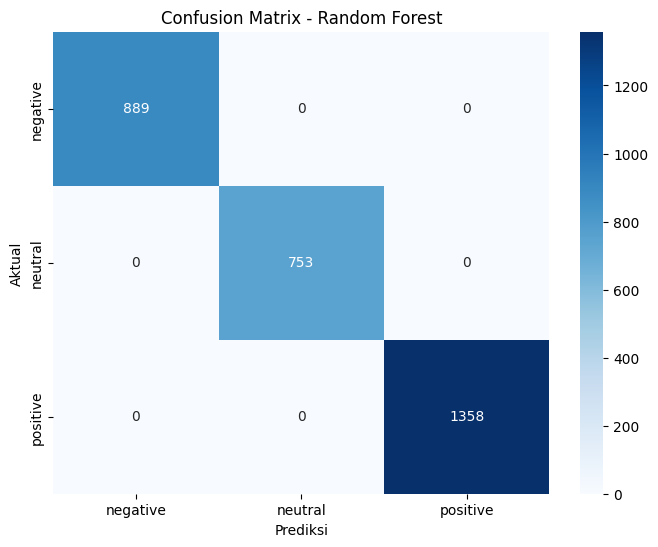

In [41]:
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
classes = np.unique(y_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


Model Random Forest menunjukkan performa yang sangat baik dengan akurasi 100%. Berdasarkan laporan klasifikasi, precision, recall, dan F1-score mencapai nilai sempurna (1.00) untuk semua kelas sentimen (Negatif, Netral, Positif). Confusion matrix mendukung hasil ini, di mana semua prediksi benar, terlihat dari nilai-nilai yang hanya terdapat pada diagonal utama tanpa kesalahan klasifikasi.